# Full simulation in Basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import * 

### Collecting Perturbations

In [6]:
sample_args = {
    "g": 9.81,
    "f": 0.0012,
    }

In [7]:
ls = [6, 7, 8, 9, 10]

In [8]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [9]:
init_model_error_basis_args = {
    "basis_x_start": 1, 
    "basis_x_end": 6,
    "basis_y_start": 2,
    "basis_y_end": 7,

    "kl_decay": 1.25,
    "kl_scaling": 0.05,
}

In [10]:
init_mekls = []
for l_idx in range(len(ls)): 
    init_mekls.append( ModelErrorKL.ModelErrorKL(**args_list[l_idx], **init_model_error_basis_args, gpu_stream=gpu_stream) 
                )

In [11]:
sim_model_error_basis_args = {
    "basis_x_start": 1, 
    "basis_x_end": 7,
    "basis_y_start": 2,
    "basis_y_end": 8,

    "kl_decay": 1.25,
    "kl_scaling": 0.0025, #0.005
}



In [12]:
data_args_list = []
for l_idx in range(len(ls)):
    data_args_list.append( make_init_steady_state(args_list[l_idx]))

### Defining Simulations

In [13]:
init_model_error = True
sim_model_error = True

In [14]:
sim = make_sim(args_list[-1], sample_args, data_args_list[-1])
if init_model_error:
    init_mekls[-1].perturbSim(sim)
if sim_model_error:
    sim.setKLModelError(**sim_model_error_basis_args)
    sim.model_time_step = 60.0

In [15]:
coarse_sim = make_sim(args_list[-2], sample_args, data_args_list[-2])
if init_model_error:
    init_mekls[-2].perturbSimSimilarAs(coarse_sim, modelError = init_mekls[-1])
if sim_model_error:
    coarse_sim.setKLModelErrorSimilarAs(sim)
    coarse_sim.model_time_step = 60.0

In [16]:
sim.dataAssimilationStep(12*3600, otherSim=coarse_sim)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

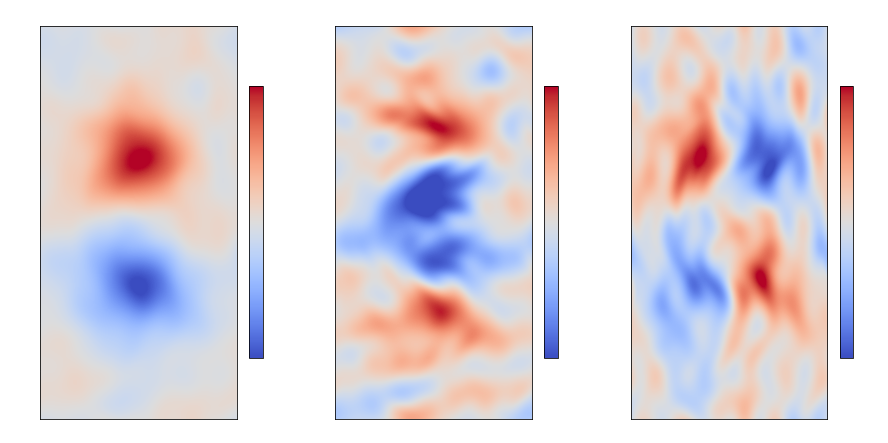

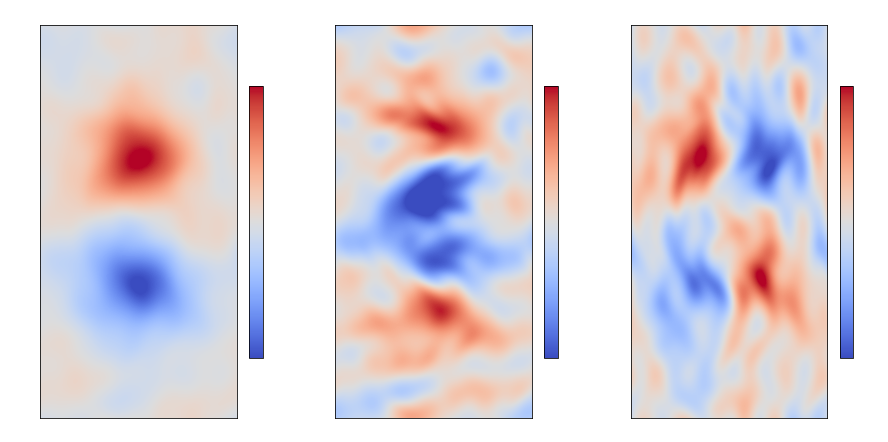

In [17]:
imshowSim(sim, eta_vlim=1, huv_vlim=25)
imshowSim(coarse_sim, eta_vlim=1, huv_vlim=25)

### Coarsest Simulation

In [18]:
sim1 = make_sim(args_list[1], sample_args, data_args_list[1])
sim0 = make_sim(args_list[0], sample_args, data_args_list[0])

if init_model_error:
    init_mekls[1].perturbSim(sim1)
    init_mekls[0].perturbSimSimilarAs(sim0, modelError=init_mekls[1])

if sim_model_error:
    sim1.setKLModelError(**sim_model_error_basis_args)
    sim0.setKLModelErrorSimilarAs(sim1)

    sim1.model_time_step = 60.0
    sim0.model_time_step = 60.0


In [19]:
sim1.dataAssimilationStep(12*3600, otherSim=sim0)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

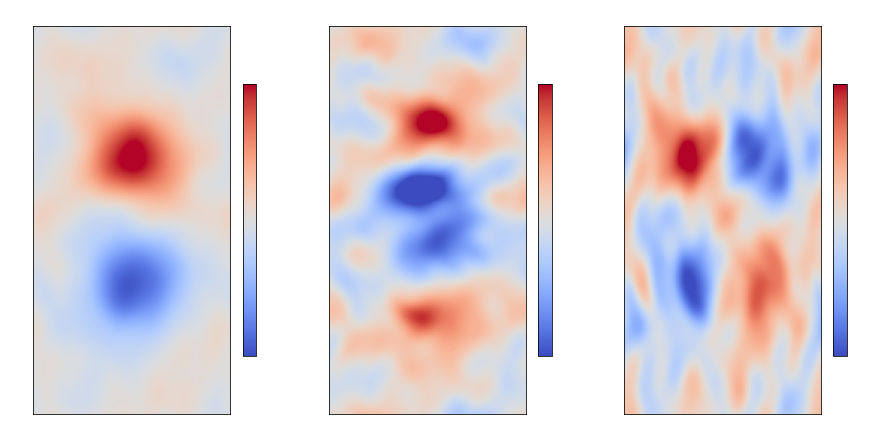

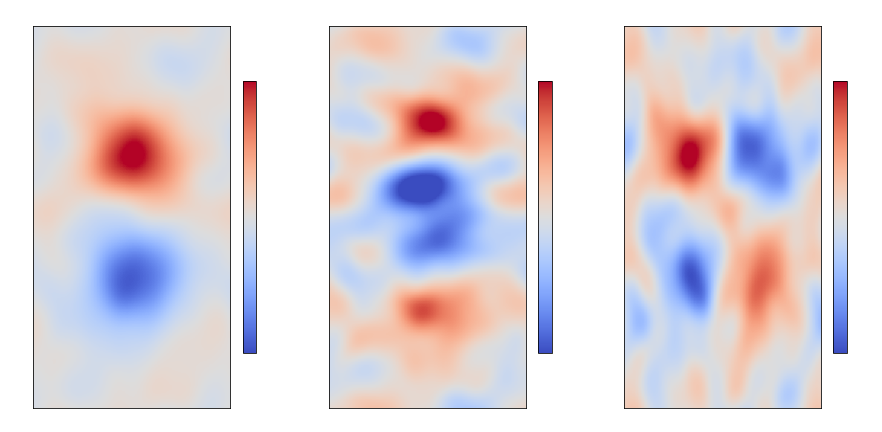

In [20]:
imshowSim(sim1, eta_vlim=1, huv_vlim=25)
imshowSim(sim0, eta_vlim=1, huv_vlim=25)